In [1]:
#导入依赖库
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import math
import numpy as np

In [2]:
#读取数据表格
data = pd.read_csv('./双金属ORR完整new.csv')
#各特征含义见原文献https://pubs.acs.org/doi/10.1021/acs.jpclett.9b03392 这里没有使用N-TM键长特征d
print(data)
#输入特征X(从0计，第9列及以后)
X = data.iloc[:,9:]
#自动拼接成numpy描述符
X = X.to_numpy()
print(X.shape)
#数据标准化(可能提高模型性能，注释该部分代码以跳过)
#X = StandardScaler().fit_transform(X)

#标签Y ΔGOH(第2列)
Y = data.iloc[:,2]
Y = Y.to_numpy()
print(Y.shape)
print('Min:',min(Y))
print('Max:',max(Y))

     DMSC  ΔGOOH  ΔGOH   ΔGO   ΔG1   ΔG2   ΔG3   ΔG4    UL     L  ...  \
0   Fe/Cr   2.88 -0.21  1.37 -2.04 -1.51 -1.58  0.21 -0.21  2.74  ...   
1   Fe/Cu   3.98  0.71  1.64 -0.94 -2.34 -0.93 -0.71  0.71  2.62  ...   
2   Fe/Fe   3.44  0.39  1.61 -1.48 -1.83 -1.22 -0.39  0.39  2.63  ...   
3   Fe/Mn   2.86 -0.22  1.30 -2.06 -1.56 -1.52  0.22 -0.22  2.78  ...   
4   Fe/Zn   3.90  0.50  1.37 -1.02 -2.53 -0.87 -0.50  0.50  2.66  ...   
5   Fe/Ni   3.43  0.58  1.85 -1.49 -1.58 -1.27 -0.58  0.58  2.58  ...   
6   Co/Co   3.49  0.35  2.16 -1.43 -1.33 -1.81 -0.35  0.35  2.61  ...   
7   Co/Cr   3.27  0.31  2.02 -1.65 -1.24 -1.72 -0.31  0.31  2.64  ...   
8   Co/Cu   3.69  0.48  2.84 -1.23 -0.85 -2.36 -0.48  0.48  2.58  ...   
9   Co/Mn   3.26  0.10  2.13 -1.66 -1.12 -2.04 -0.10  0.10  2.75  ...   
10  Co/Ni   3.38  0.51  1.89 -1.54 -1.49 -1.37 -0.51  0.51  2.62  ...   
11  Co/Zn   3.06  0.17  2.02 -1.86 -1.04 -1.86 -0.17  0.17  2.65  ...   
12  Co/Pt   3.51  0.65  2.42 -1.41 -1.09 -1.77 -0.6

In [3]:
#超参数设置可能不合理，训练中会出现警告信息，可以忽略掉(如不忽略请注释掉代码)
import warnings
warnings.filterwarnings("ignore")
#构建GBR模型(文献中也使用该模型)
model = GradientBoostingRegressor(n_estimators=300, max_depth=2, max_features='auto') #效果很差
#设定可调超参数空间(采样率 损失函数 学习率 迭代次数 深度)(自行尝试引入更多参数) 其余使用默认参数
tuned_parameters = [
    {"subsample": [0.4,0.8,1], "loss":["squared_error", "absolute_error", "huber"],
     "learning_rate":[0.001,0.01],
    },]
#"max_depth":[2,3,4] "n_estimators":[100,200,300]
#构建相应的交叉验证超参搜索器(这里使用网格搜索) 使用平均误差MAE的负数作为评分指标
#10-FOLD
clf = GridSearchCV(model, tuned_parameters, scoring="neg_mean_absolute_error", cv=10)
#反复训练并搜索最佳超参
clf.fit(X,Y)
#输出结果(指标用MAE)
print("当前数据集上的最佳模型超参数设置:")
print(clf.best_params_)
print("相应评分：")
print("%0.3f eV" %(-clf.best_score_))
print()
print("各超参数设置及相应模型评分(评分/±标准差):")
means = -clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f eV (+/-%0.03f eV) for %r" % (mean, std * 2, params))

当前数据集上的最佳模型超参数设置:
{'learning_rate': 0.01, 'loss': 'squared_error', 'subsample': 0.4}
相应评分：
0.143 eV

各超参数设置及相应模型评分(评分/±标准差):
0.211 eV (+/-0.116 eV) for {'learning_rate': 0.001, 'loss': 'squared_error', 'subsample': 0.4}
0.206 eV (+/-0.115 eV) for {'learning_rate': 0.001, 'loss': 'squared_error', 'subsample': 0.8}
0.202 eV (+/-0.113 eV) for {'learning_rate': 0.001, 'loss': 'squared_error', 'subsample': 1}
0.224 eV (+/-0.129 eV) for {'learning_rate': 0.001, 'loss': 'absolute_error', 'subsample': 0.4}
0.226 eV (+/-0.126 eV) for {'learning_rate': 0.001, 'loss': 'absolute_error', 'subsample': 0.8}
0.225 eV (+/-0.120 eV) for {'learning_rate': 0.001, 'loss': 'absolute_error', 'subsample': 1}
0.219 eV (+/-0.121 eV) for {'learning_rate': 0.001, 'loss': 'huber', 'subsample': 0.4}
0.214 eV (+/-0.119 eV) for {'learning_rate': 0.001, 'loss': 'huber', 'subsample': 0.8}
0.210 eV (+/-0.117 eV) for {'learning_rate': 0.001, 'loss': 'huber', 'subsample': 1}
0.143 eV (+/-0.105 eV) for {'learning_rate': 0.

(-1.0, 2.0)

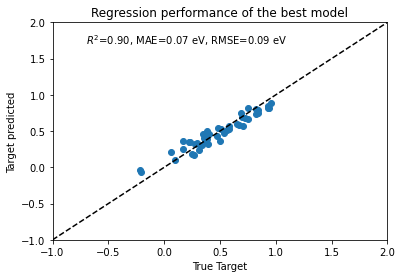

In [4]:
#可视化交叉验证得到的最优模型在整个数据集上的性能

#获取最优模型
best_model = clf.best_estimator_
#预测
Y_pred = best_model.predict(X)
#绘制
fig, ax = plt.subplots()
#绘制预测-真值对散点
ax.scatter(Y,Y_pred)
#绘制对角线
ax.plot([-1,2], [-1,2], "--k")
ax.set_ylabel("Target predicted")
ax.set_xlabel("True Target")
ax.set_title("Regression performance of the best model")
#计算决定系数R2,MAE以及RMSE作为图注
ax.text(
    -0.7,
    1.7,
    r"$R^2$=%.2f, MAE=%.2f eV, RMSE=%.2f eV"
    % (r2_score(Y, Y_pred), mean_absolute_error(Y, Y_pred), math.sqrt(mean_squared_error(Y, Y_pred))),
)
#x y轴上下限
ax.set_xlim([-1,2])
ax.set_ylim([-1,2])

(-1.0, 2.0)

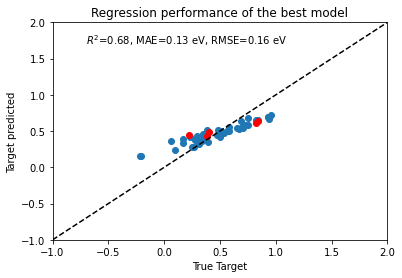

In [5]:
#基于最优参数再单独训练一个新模型，进行一次留一验证，测试集比例0.1(和文献一样)
from sklearn.model_selection import train_test_split
#分配训练集，验证集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
#基于最优参数训练新模型
model = GradientBoostingRegressor(**clf.best_params_)
model.fit(X_train, y_train)

#分别预测
Y_pred = model.predict(X)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
#绘制
fig, ax = plt.subplots()
#绘制预测-真值对散点
#训练集数据点
ax.scatter(y_train,y_train_pred)
#测试集数据点(红色)
ax.scatter(y_test,y_test_pred,color='r')
#绘制对角线
ax.plot([-1,2], [-1,2], "--k")
ax.set_ylabel("Target predicted")
ax.set_xlabel("True Target")
ax.set_title("Regression performance of the best model")
#计算整个数据集的决定系数R2和MAE作为图注
ax.text(
    -0.7,
    1.7,
    r"$R^2$=%.2f, MAE=%.2f eV, RMSE=%.2f eV"
    % (r2_score(Y, Y_pred), mean_absolute_error(Y, Y_pred), math.sqrt(mean_squared_error(Y, Y_pred))),
)
#x y轴上下限
ax.set_xlim([-1,2])
ax.set_ylim([-1,2])

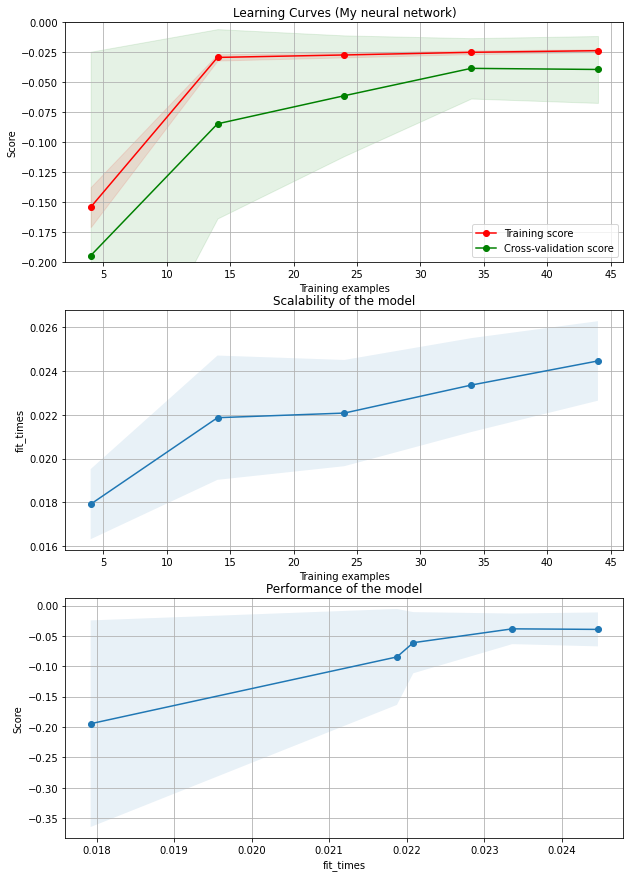

In [6]:
#用多种可视化曲线更全面地分析我们的最优模型

#自定义绘制曲线的方法
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    score="neg_mean_squared_error",
    axes=None,
    ylim=None,
    cv=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    绘制3种曲线: 学习曲线, 训练样本数-拟合时间曲线, 拟合时间-分数曲线.(拟合时间可以看作迭代次数)

    参数
    ----------
    estimator : 模型

    title : 曲线图标题

    X : 输入描述符

    y : 标签
    
    score :使用的评分指标 默认使用MSE的负数，越正越好

    axes : 用于绘制曲线的坐标轴(三个)

    ylim : 设定图中纵轴的上下限 (ymin, ymax).

    cv : 交叉验证参数 如传入整数k即进行k-fold交叉验证 也可直接传入已定义的样本分配(如ShuffleSplit)

    train_sizes : 使用的训练样本数量或占数据集比例(对应横轴刻度)
    """

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    #使用learning_curve()方法，可自动交叉验证并返回各种统计信息
    #训练使用的训练集数目逐次增加
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=score,
        train_sizes=train_sizes,
        return_times=True,
    )
    #计算性能指标平均值和标准差
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    #绘制学习曲线
    #绘制网格
    axes[0].grid()
    #指标波动范围(指标标准差，反映模型稳定性，或说泛化能力)
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    #以指标均值绘制曲线
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    #图例
    axes[0].legend(loc="best")

    #绘制训练样本数-拟合时间曲线
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    #绘制拟合时间-分数曲线
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
#3行2列
#如果各图有重叠或靠的太近 自行调大figsize的宽高
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

#自定义样本分配
#cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

title = "Learning Curves (My neural network)"

#使用我们自己搜索到的最佳超参
estimator = GradientBoostingRegressor(**clf.best_params_)
#绘制3种曲线 如果纵轴范围不合理 则自行调整ylim
#建议使用较大的交叉验证次数(cv)，以减小每次测试平均指标的不确定性，有利于曲线平滑
plot_learning_curve(
    estimator, title, X, Y, axes=axes, ylim=(-0.2, 0), cv=20,
)
plt.show()